### Re-adressing bad electrode detection in PANDA

When PANDA was run on the new dataset, some strange and not very reasonable looking results were returned. An example of this can be seen below:

In [1]:
# Getting the data
%matplotlib inline
import cPickle as pkl
base = '../../data/bids_raw/sub-0001/ses-01/eeg/'
path = ''
file_name = 'sub-0001_ses-01.pkl'
full_path = base + path + file_name
with open(full_path, 'rb') as f:
    D = pkl.load(f)
with open('../../data/bids_raw/chan_locs.pkl') as f:
    chan_locs = pkl.load(f)

In [2]:
# Import packages and configure pipeline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from panda.methods.misc import setup
from panda.methods.denoise import highpass
from panda.methods.bad_chans import bad_detec
from panda.methods.denoise import wave_rejection
from panda.methods.denoise import eog_regress
from panda.methods.denoise import amp_shrinkage
from panda.methods import viz as viz
from panda import config
p_global = config.params['p_global']
eog_chans = np.array(p_global['eog_chans']) - 1
eeg_chans = np.setdiff1d(np.arange(128), eog_chans)
p_global.update({'eog_chans': eog_chans,
                'eeg_chans': eeg_chans})
p_global['inter'].update({'chan_locs': chan_locs})
p_global['plotting']['notebook'] = True

After Mean Centering


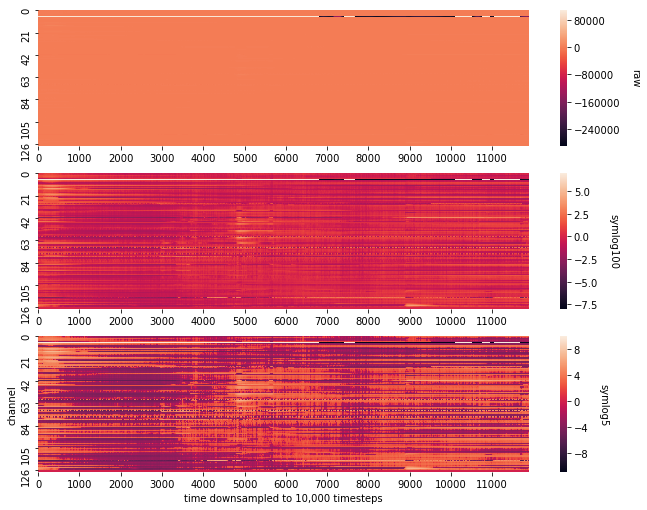

After highpass


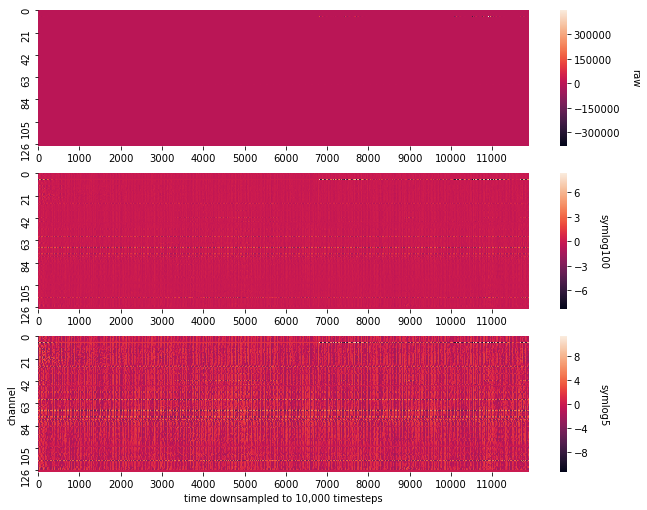

After eog regression


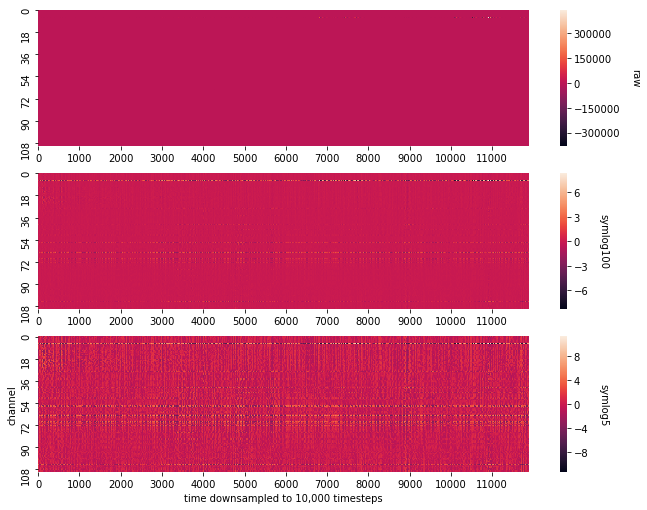

After wave rejection


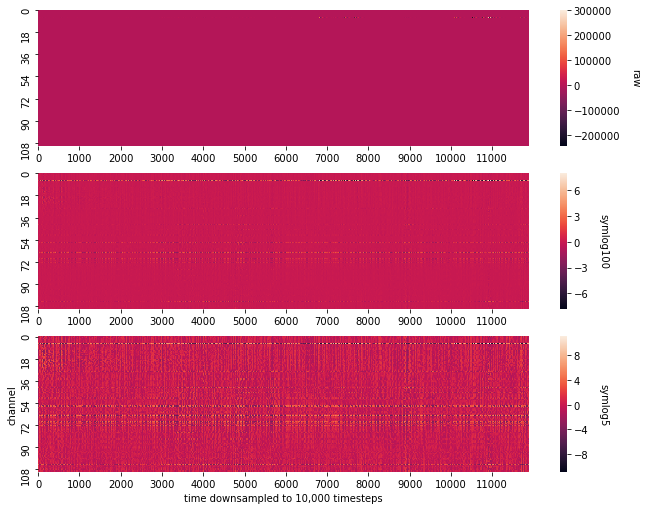

After amp shrinkage


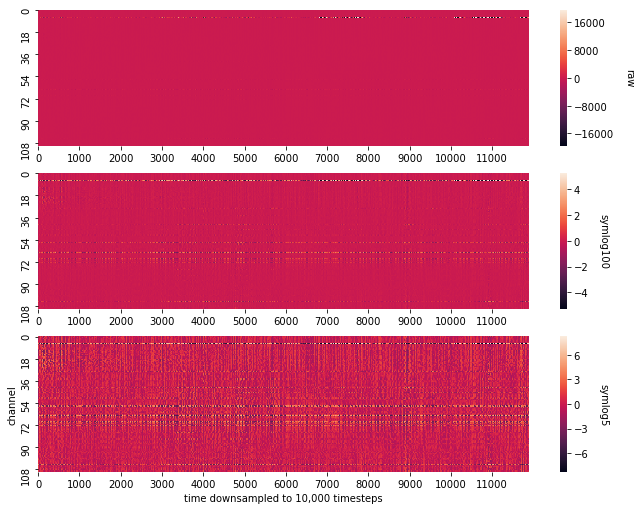

Channels which are zero []
Channels determined bad by prob : [  6  15  23  42  58  79 105]
Channels determined bad by kurtosis : [15 23 31 58]
Channels determined bad by std : [6]
Channels determined bad by spread : [6]
Channels determined bad by max : [6]
All channels removed [  6  15  23  42  58  79 105  15  23  31  58   6   6   6]
After bad electrode detection


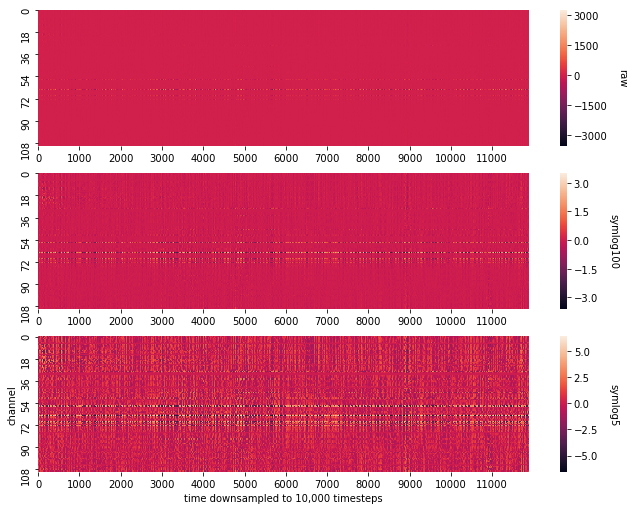

In [3]:
# Running the full pipeline on HBNB data
(D, p_local) = setup(D, {'eog_in': False}, p_global)
print "After Mean Centering"
viz.heatmap(D, p_local, p_global)
#(D, p_local) = bad_detec(D, p_local, p_global)
(D, p_local) = highpass(D, p_local, p_global)
print "After highpass"
viz.heatmap(D, p_local, p_global)
(D, p_local) = eog_regress(D, p_local, p_global)
print "After eog regression"
viz.heatmap(D, p_local, p_global)
(D, p_local) = wave_rejection(D, p_local, p_global)
print "After wave rejection"
viz.heatmap(D, p_local, p_global)
(D, p_local) = amp_shrinkage(D, p_local, p_global)
print "After amp shrinkage"
viz.heatmap(D, p_local, p_global)
(D, p_local) = bad_detec(D, p_local, p_global)
print "After bad electrode detection"
viz.heatmap(D, p_local, p_global)

Here, there is a bad electrode (#6) which has a character that was not seen in previous datasets that PANDA was run on. Since this channel is present in the dataframe before global denoising steps (eog regression, for example) it is likely going to carry noise through to the end matrix, as can be seen by the last step heatmap having an unusually large range

We can see electrode 6 here:

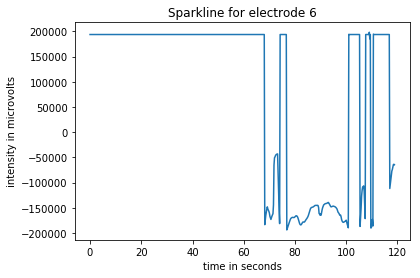

In [11]:
with open(full_path, 'rb') as f:
    D = pkl.load(f)
with open('../../data/bids_raw/chan_locs.pkl') as f:
    chan_locs = pkl.load(f)
import seaborn as sns
import matplotlib.pyplot as plt
plt.plot(np.arange(D.shape[1])[::100] * 1./500, D[6, ::100])
plt.xlabel("time in seconds")
plt.ylabel('intensity in microvolts')
plt.title("Sparkline for electrode 6")
plt.show()

Experimentation revealed that a good way to address this issue is to remove gross outlier electrodes before any global steps in the pipeline (e.g. any denoising based on all channel values rather than just the values from one channel). We try this below.

After Mean Centering


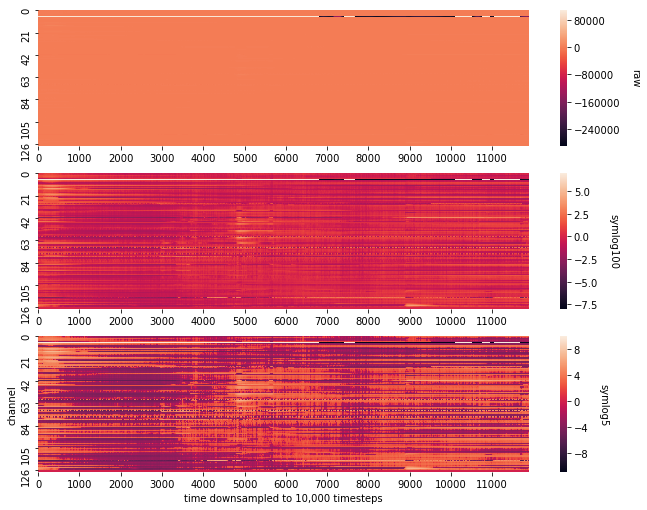

After highpass


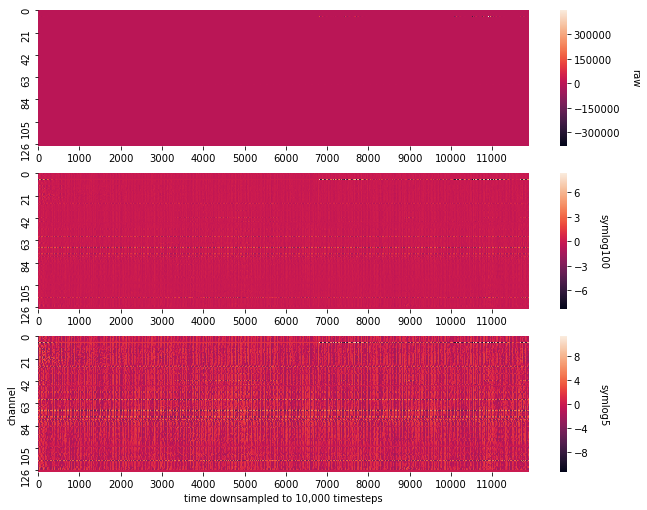

Channels which are zero [127]
Channels determined bad by prob : [  6  10  40 103 108 109 114]
Channels determined bad by kurtosis : [  5  10  31  40 103 108 109 114]
Channels determined bad by std : [6]
Channels determined bad by spread : [6]
Channels determined bad by max : [6]
All channels removed [127   6  10  40 103 108 109 114   5  10  31  40 103 108 109 114   6   6
   6]
After bad electrode detection


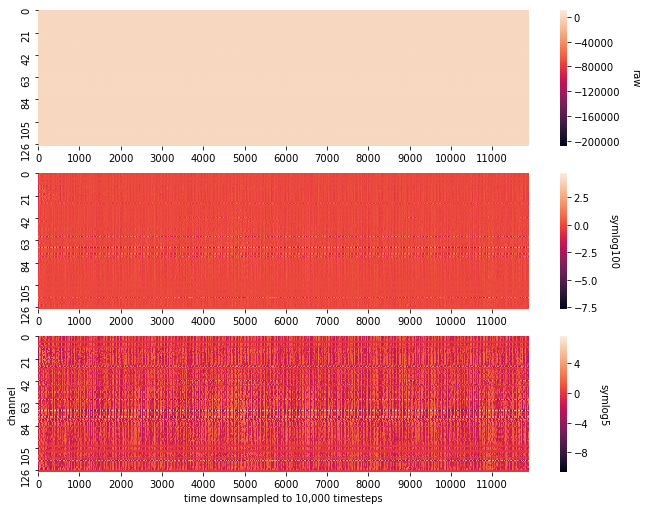

After eog regression


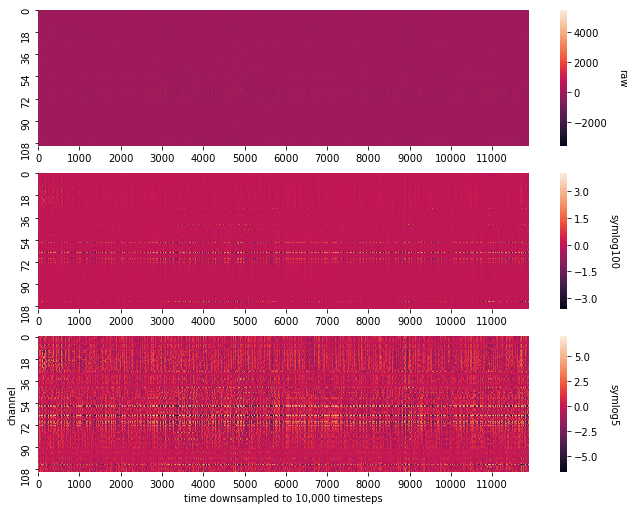

After wave rejection


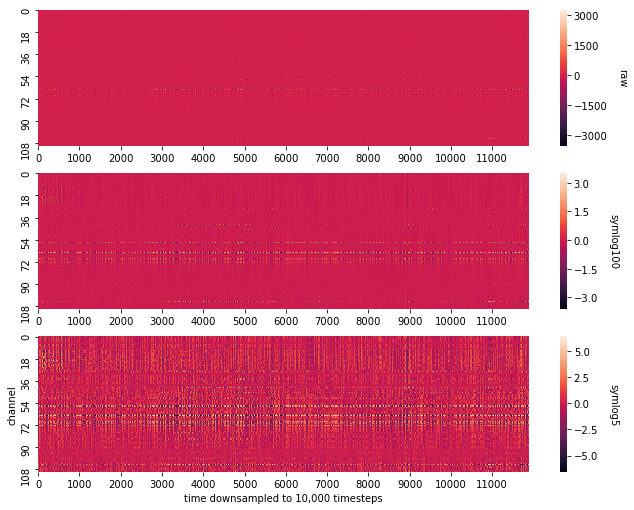

After amp shrinkage


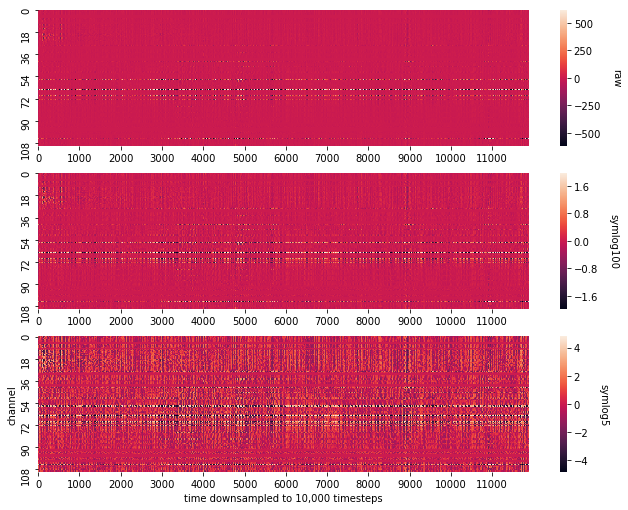

In [12]:
# Running the full pipeline on HBNB data, baddetec moved
(D, p_local) = setup(D, {'eog_in': False}, p_global)
print "After Mean Centering"
viz.heatmap(D, p_local, p_global)
(D, p_local) = highpass(D, p_local, p_global)
print "After highpass"
viz.heatmap(D, p_local, p_global)
(D, p_local) = bad_detec(D, p_local, p_global)
print "After bad electrode detection"
viz.heatmap(D, p_local, p_global)
#(D, p_local) = bad_detec(D, p_local, p_global)
(D, p_local) = eog_regress(D, p_local, p_global)
print "After eog regression"
viz.heatmap(D, p_local, p_global)
(D, p_local) = wave_rejection(D, p_local, p_global)
print "After wave rejection"
viz.heatmap(D, p_local, p_global)
(D, p_local) = amp_shrinkage(D, p_local, p_global)
print "After amp shrinkage"
viz.heatmap(D, p_local, p_global)

The signal returned in the second ordering of the pipel